# Regression avec lags et XGB

In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [83]:
data_X = pd.read_csv('x_train.csv')
data_X['date']=pd.to_datetime(data_X['date'])
data_y = pd.read_csv('y_train.csv')
data_X['y']=data_y['y']
data_X=data_X.set_index(['date'])
data_X = data_X.sort_index()
nb_stations=data_X['station'].unique()
nb_station = len(nb_stations)


data_X.head()

,station,job,ferie,vacances,y
date,,,,,
2015-01-01,1J7,1,1,1,7
2015-01-01,S3E,1,1,1,103
2015-01-01,RDK,1,1,1,98
2015-01-01,I9U,1,1,1,277
2015-01-01,OM7,1,1,1,398


In [84]:
print(data_X['job'][3])

1


On va d'abord tester pour une seule station

In [85]:
np.shape(nb_stations)

(439,)

In [86]:
station = 'XTG'
data_X_station = data_X[data_X['station']==station]
data_X_station.head()


,station,job,ferie,vacances,y
date,,,,,
2015-01-01,XTG,1,1,1,1535
2015-01-02,XTG,1,0,1,6262
2015-01-03,XTG,0,0,1,5127
2015-01-04,XTG,0,0,1,2992
2015-01-05,XTG,1,0,0,12151


In [87]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
data_X_station = data_X_station.sort_index()

In [88]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    # df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    # df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    # df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    # df['weekofyear'] = df.index.isocalendar().week
    return df

data_X_station = create_features(data_X_station)
data_X_station.head()

,station,job,ferie,vacances,y,dayofweek,month,year,dayofmonth
date,,,,,,,,,
2015-01-01,XTG,1,1,1,1535,3,1,2015,1
2015-01-02,XTG,1,0,1,6262,4,1,2015,2
2015-01-03,XTG,0,0,1,5127,5,1,2015,3
2015-01-04,XTG,0,0,1,2992,6,1,2015,4
2015-01-05,XTG,1,0,0,12151,0,1,2015,5


In [89]:
def add_lags(df):
    target_map = df['y'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('183 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('184 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('185 days')).map(target_map)
    df['lag4'] = (df.index - pd.Timedelta('186 days')).map(target_map)
    df['lag5'] = (df.index - pd.Timedelta('187 days')).map(target_map)
    df['lag6'] = (df.index - pd.Timedelta('1473 days')).map(target_map)
    df['lag7'] = (df.index - pd.Timedelta('1472 days')).map(target_map)
    df['lag8'] = (df.index - pd.Timedelta('1471 days')).map(target_map)
    df['lag9'] = (df.index - pd.Timedelta('1470 days')).map(target_map)
    df['lag10'] = (df.index - pd.Timedelta('1461 days')).map(target_map)
    df['lag11'] = (df.index - pd.Timedelta('1462 days')).map(target_map)
    df['lag12'] = (df.index - pd.Timedelta('1463 days')).map(target_map)
    df['lag13'] = (df.index - pd.Timedelta('1467 days')).map(target_map)
    df['lag14'] = (df.index - pd.Timedelta('1468 days')).map(target_map)
    df['lag15'] = (df.index - pd.Timedelta('1469 days')).map(target_map)
    df['lag16'] = (df.index - pd.Timedelta('1464 days')).map(target_map)
    df['lag17'] = (df.index - pd.Timedelta('1465 days')).map(target_map)
    df['lag18'] = (df.index - pd.Timedelta('1466 days')).map(target_map)
    return df

data_X_station = add_lags(data_X_station)
data_X_station.tail()

,station,job,ferie,vacances,y,dayofweek,month,year,dayofmonth,lag1,...,lag9,lag10,lag11,lag12,lag13,lag14,lag15,lag16,lag17,lag18
date,,,,,,,,,,,,,,,,,,,,,
2022-12-27,XTG,1,0,1,9092,1,12,2022,27,12794.0,...,15908.0,572.0,9433.0,3959.0,15534.0,15599.0,15476.0,8130.0,5571.0,8740.0
2022-12-28,XTG,1,0,1,9869,2,12,2022,28,13258.0,...,15476.0,10152.0,572.0,9433.0,8740.0,15534.0,15599.0,3959.0,8130.0,5571.0
2022-12-29,XTG,1,0,1,9896,3,12,2022,29,13026.0,...,15599.0,7719.0,10152.0,572.0,5571.0,8740.0,15534.0,9433.0,3959.0,8130.0
2022-12-30,XTG,1,0,1,8799,4,12,2022,30,12317.0,...,15534.0,5230.0,7719.0,10152.0,8130.0,5571.0,8740.0,572.0,9433.0,3959.0
2022-12-31,XTG,0,0,1,6006,5,12,2022,31,11522.0,...,8740.0,5940.0,5230.0,7719.0,3959.0,8130.0,5571.0,10152.0,572.0,9433.0


In [90]:
tss = TimeSeriesSplit(n_splits=2, test_size=365, gap=0)
data_X_station = data_X_station.sort_index()


fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(data_X_station):
    train = data_X_station.iloc[train_idx]
    test = data_X_station.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ['dayofweek', 'month','year','dayofmonth',
                # 'lag1','lag2','lag3',
                # 'lag4','lag5',
                'lag6',
                'lag7','lag8','lag9',
                'lag10','lag11','lag12',
                'lag13','lag14','lag15',
                'lag16','lag17','lag18',
                'job','vacances','ferie']
    TARGET = 'y'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=600,
                           early_stopping_rounds=50,
                           objective='reg:squarederror',
                           max_depth=8,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[0]	validation_0-rmse:10758.38963	validation_1-rmse:9032.30691
[100]	validation_0-rmse:4336.98843	validation_1-rmse:5778.83294
[200]	validation_0-rmse:2192.09925	validation_1-rmse:4921.21818
[300]	validation_0-rmse:1499.62110	validation_1-rmse:4590.54276
[400]	validation_0-rmse:1256.29395	validation_1-rmse:4479.02071
[500]	validation_0-rmse:1101.50040	validation_1-rmse:4440.77437
[599]	validation_0-rmse:1006.59939	validation_1-rmse:4429.94668
[0]	validation_0-rmse:10525.76327	validation_1-rmse:10465.37512
[100]	validation_0-rmse:4238.66502	validation_1-rmse:5743.72981
[200]	validation_0-rmse:2112.73297	validation_1-rmse:4285.28929
[300]	validation_0-rmse:1357.82085	validation_1-rmse:3874.17928
[400]	validation_0-rmse:1141.70154	validation_1-rmse:3711.54749
[500]	validation_0-rmse:1007.17912	validation_1-rmse:3652.40242
[599]	validation_0-rmse:940.04591	validation_1-rmse:3630.00603


In [91]:
scores

[4429.946693644176, 3629.7944171241115]

In [92]:
# Create future dataframe
future = pd.date_range('2023-01-01','2023-06-30', freq='D')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
X_a_tester = pd.read_csv('x_test.csv')
X_a_tester = X_a_tester[X_a_tester['station']==station]
X_a_tester['date'] = pd.to_datetime(X_a_tester['date'])
X_a_tester = X_a_tester.set_index(['date'])
#X_a_tester = X_a_tester.sort_index()
display(X_a_tester)
future_df['job'] = X_a_tester['job']
future_df['ferie'] = X_a_tester['ferie']
future_df['vacances'] = X_a_tester['vacances']
future_df['station'] = X_a_tester['station']
display(future_df)
data_X_station['isFuture'] = False
df_and_future = pd.concat([data_X_station, future_df])
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

,index,station,job,ferie,vacances
date,,,,,
2023-01-01,2023-01-01_XTG,XTG,0,1,1
2023-02-01,2023-02-01_XTG,XTG,1,0,0
2023-03-01,2023-03-01_XTG,XTG,1,0,1
2023-04-01,2023-04-01_XTG,XTG,0,0,0
2023-05-01,2023-05-01_XTG,XTG,1,1,1
...,...,...,...,...,...
2023-05-30,2023-05-30_XTG,XTG,1,0,0
2023-06-30,2023-06-30_XTG,XTG,1,0,0
2023-01-31,2023-01-31_XTG,XTG,1,0,0


,isFuture,job,ferie,vacances,station
2023-01-01,True,0.0,1.0,1.0,XTG
2023-01-02,True,1.0,0.0,1.0,XTG
2023-01-03,True,1.0,0.0,0.0,XTG
2023-01-04,True,1.0,0.0,0.0,XTG
2023-01-05,True,1.0,0.0,0.0,XTG
...,...,...,...,...,...
2023-06-26,True,1.0,0.0,0.0,XTG
2023-06-27,True,1.0,0.0,0.0,XTG
2023-06-28,True,1.0,0.0,0.0,XTG
2023-06-29,True,1.0,0.0,0.0,XTG


In [93]:
df_and_future.tail()

,station,job,ferie,vacances,y,dayofweek,month,year,dayofmonth,lag1,...,lag10,lag11,lag12,lag13,lag14,lag15,lag16,lag17,lag18,isFuture
2023-06-26,XTG,1.0,0.0,0.0,NaN,0,6,2023,26,3570.0,...,14354.0,14838.0,14650.0,15023.0,14659.0,14993.0,4982.0,8505.0,15992.0,True
2023-06-27,XTG,1.0,0.0,0.0,NaN,1,6,2023,27,9061.0,...,12602.0,14354.0,14838.0,15992.0,15023.0,14659.0,14650.0,4982.0,8505.0,True
2023-06-28,XTG,1.0,0.0,0.0,NaN,2,6,2023,28,9092.0,...,14381.0,12602.0,14354.0,8505.0,15992.0,15023.0,14838.0,14650.0,4982.0,True
2023-06-29,XTG,1.0,0.0,0.0,NaN,3,6,2023,29,9869.0,...,8930.0,14381.0,12602.0,4982.0,8505.0,15992.0,14354.0,14838.0,14650.0,True
2023-06-30,XTG,1.0,0.0,0.0,NaN,4,6,2023,30,9896.0,...,5948.0,8930.0,14381.0,14650.0,4982.0,8505.0,12602.0,14354.0,14838.0,True


In [94]:
future_w_features = df_and_future.query('isFuture').copy()

In [95]:
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])

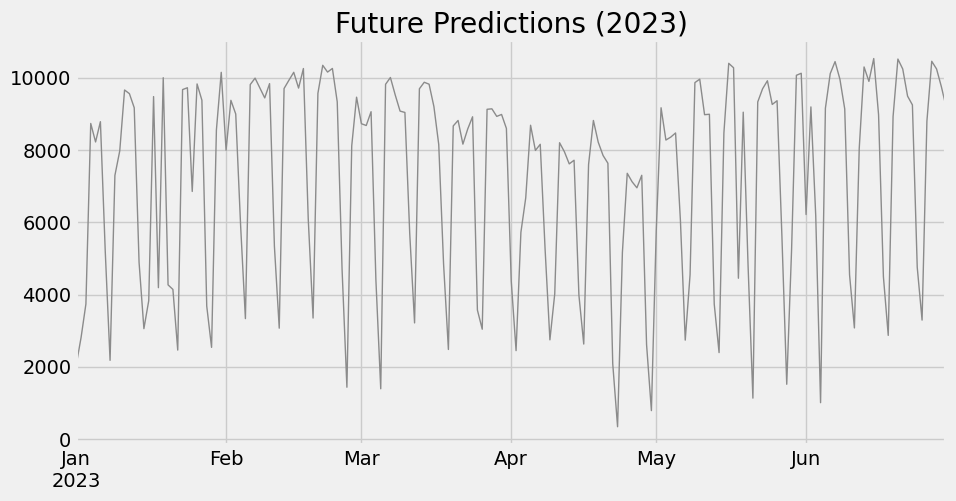

,station,job,ferie,vacances,y,dayofweek,month,year,dayofmonth,lag1,...,lag11,lag12,lag13,lag14,lag15,lag16,lag17,lag18,isFuture,pred
2023-01-01,XTG,0.0,1.0,1.0,NaN,6,1,2023,1,7716.0,...,5940.0,5230.0,9433.0,3959.0,8130.0,7719.0,10152.0,572.0,True,2057.291504
2023-01-02,XTG,1.0,0.0,1.0,NaN,0,1,2023,2,4566.0,...,2028.0,5940.0,572.0,9433.0,3959.0,5230.0,7719.0,10152.0,True,2808.363770
2023-01-03,XTG,1.0,0.0,0.0,NaN,1,1,2023,3,12183.0,...,9475.0,2028.0,10152.0,572.0,9433.0,5940.0,5230.0,7719.0,True,3737.269775
2023-01-04,XTG,1.0,0.0,0.0,NaN,2,1,2023,4,12834.0,...,10899.0,9475.0,7719.0,10152.0,572.0,2028.0,5940.0,5230.0,True,8735.293945
2023-01-05,XTG,1.0,0.0,0.0,NaN,3,1,2023,5,10977.0,...,10977.0,10899.0,5230.0,7719.0,10152.0,9475.0,2028.0,5940.0,True,8223.676758


In [96]:
future_w_features['pred'].plot(figsize=(10, 5),
                               color=color_pal[4],
                               ms=1,
                               lw=1,
                               title='Future Predictions (2023)')
plt.show()
future_w_features.head()

<AxesSubplot: title={'center': '2019'}, xlabel='date'>

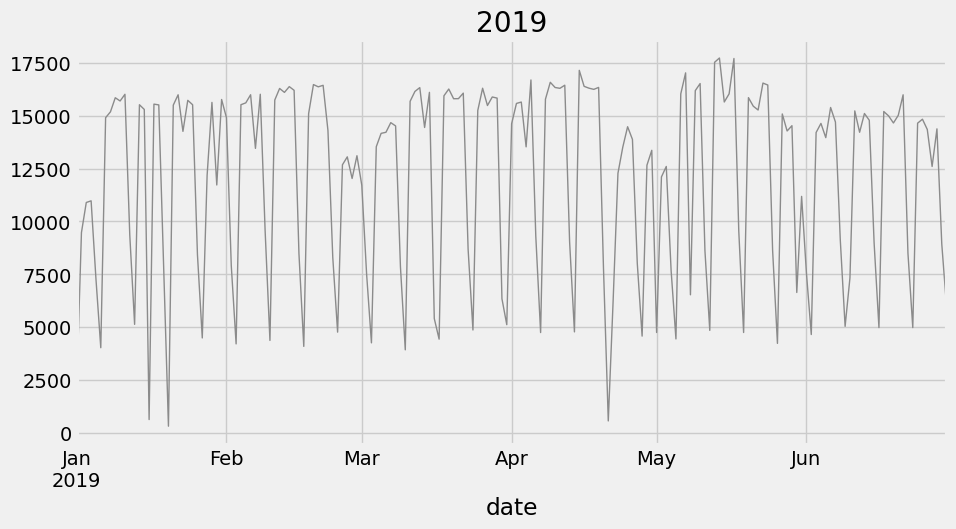

In [97]:
data_2022 = data_X_station[data_X_station['year']==2019]
data_2022 = data_2022[(data_2022.index.month >= 1) & (data_2022.index.month <= 6)]
data_2022['y'].plot(figsize=(10, 5),
                               color=color_pal[4],
                               ms=1,
                               lw=1,
                               title='2019')


On essaye avec seulement la fin de l'année en predict

In [98]:
#tss = TimeSeriesSplit(n_splits=2, test_size=365, gap=0)
data_X_station = data_X_station.sort_index()


fold = 0
preds = []
scores = []

train = data_X_station[:-183]
test = data_X_station[-183:]

train = create_features(train)
test = create_features(test)

FEATURES = ['dayofweek', 'month','year','dayofmonth',
        #     'lag1','lag2','lag3',
        #     'lag4','lag5',
            'lag6',
            'lag7','lag8','lag9',
            'lag10','lag11','lag12',
            'lag13','lag14','lag15',
            'lag16','lag17','lag18',
            'job','vacances','ferie']
TARGET = 'y'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

reg = xgb.XGBRegressor(booster='gbtree',    
                        n_estimators=2000,
                        early_stopping_rounds=50,
                        objective='reg:squarederror',
                        max_depth=15,
                        learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

y_pred = reg.predict(X_test)
preds.append(y_pred)
score = np.sqrt(mean_squared_error(y_test, y_pred))
scores.append(score)

[0]	validation_0-rmse:4607.01233	validation_1-rmse:4828.29633
[100]	validation_0-rmse:1946.36913	validation_1-rmse:4019.59322
[200]	validation_0-rmse:907.38857	validation_1-rmse:3927.53419
[286]	validation_0-rmse:510.83568	validation_1-rmse:3935.67988


In [99]:
scores

[3921.3926764709076]

In [100]:
scores = []
scores_train = []
for n_estimators in range(50,2050,50):
    reg = xgb.XGBRegressor(booster='gbtree',    
                        n_estimators=n_estimators,
                        #early_stopping_rounds=50,
                        objective='reg:squarederror',
                        max_depth=5,
                        learning_rate=0.01)
    reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

    y_pred = reg.predict(X_test)
    y_train_pred = reg.predict(X_train)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    score_train = np.sqrt(mean_squared_error(y_train,y_train_pred))
    scores.append(score)
    scores_train.append(score_train)

[0]	validation_0-rmse:4617.04055	validation_1-rmse:4822.73856


[49]	validation_0-rmse:3497.97322	validation_1-rmse:3997.86896
[0]	validation_0-rmse:4617.04055	validation_1-rmse:4822.73856
[99]	validation_0-rmse:2906.16673	validation_1-rmse:3572.67838
[0]	validation_0-rmse:4617.04055	validation_1-rmse:4822.73856
[100]	validation_0-rmse:2896.14814	validation_1-rmse:3565.47731
[149]	validation_0-rmse:2548.40122	validation_1-rmse:3390.48976
[0]	validation_0-rmse:4617.04055	validation_1-rmse:4822.73856
[100]	validation_0-rmse:2896.14814	validation_1-rmse:3565.47731
[199]	validation_0-rmse:2347.71555	validation_1-rmse:3327.12003
[0]	validation_0-rmse:4617.04055	validation_1-rmse:4822.73856
[100]	validation_0-rmse:2896.14814	validation_1-rmse:3565.47731
[200]	validation_0-rmse:2344.93276	validation_1-rmse:3325.88049
[249]	validation_0-rmse:2207.04836	validation_1-rmse:3335.28083
[0]	validation_0-rmse:4617.04055	validation_1-rmse:4822.73856
[100]	validation_0-rmse:2896.14814	validation_1-rmse:3565.47731
[200]	validation_0-rmse:2344.93276	validation_1-rmse

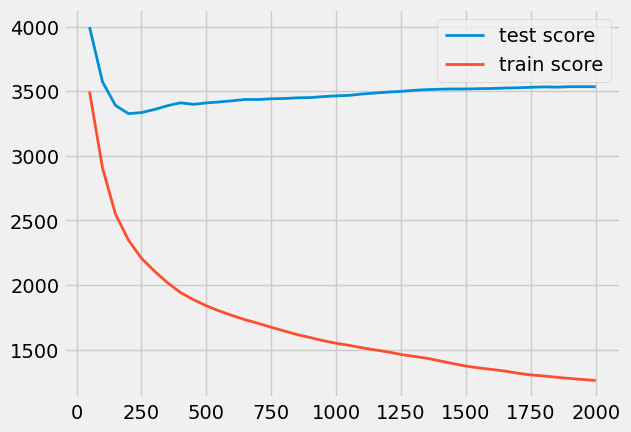

In [101]:
estimators = np.arange(50,2050,50)
plt.plot(estimators,scores,linewidth = 2,label = 'test score')
plt.plot(estimators,scores_train,linewidth = 2,label = 'train score')
plt.legend()

In [102]:
scores = []
scores_train = []
for depth in range(1,31):
    reg = xgb.XGBRegressor(booster='gbtree',    
                        n_estimators=500,
                        early_stopping_rounds=50,
                        objective='reg:squarederror',
                        max_depth=depth,
                        learning_rate=0.01)
    reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

    y_pred = reg.predict(X_test)
    y_train_pred = reg.predict(X_train)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    score_train = np.sqrt(mean_squared_error(y_train,y_train_pred))
    scores.append(score)
    scores_train.append(score_train)

[0]	validation_0-rmse:4631.25556	validation_1-rmse:4827.12027


[100]	validation_0-rmse:3777.87983	validation_1-rmse:4175.22423
[200]	validation_0-rmse:3492.61794	validation_1-rmse:3885.94138
[300]	validation_0-rmse:3313.10711	validation_1-rmse:3743.45897
[400]	validation_0-rmse:3200.15356	validation_1-rmse:3661.29375
[499]	validation_0-rmse:3127.87376	validation_1-rmse:3561.58332
[0]	validation_0-rmse:4626.73991	validation_1-rmse:4829.09971
[100]	validation_0-rmse:3442.64528	validation_1-rmse:3872.32858
[200]	validation_0-rmse:3073.30802	validation_1-rmse:3615.14995
[300]	validation_0-rmse:2870.59416	validation_1-rmse:3391.74160
[400]	validation_0-rmse:2754.17944	validation_1-rmse:3250.40125
[499]	validation_0-rmse:2688.59136	validation_1-rmse:3158.66994
[0]	validation_0-rmse:4622.56766	validation_1-rmse:4824.86443
[100]	validation_0-rmse:3256.45356	validation_1-rmse:3856.49335
[200]	validation_0-rmse:2885.54240	validation_1-rmse:3436.66461
[300]	validation_0-rmse:2597.38123	validation_1-rmse:3231.20533
[400]	validation_0-rmse:2447.50224	validatio

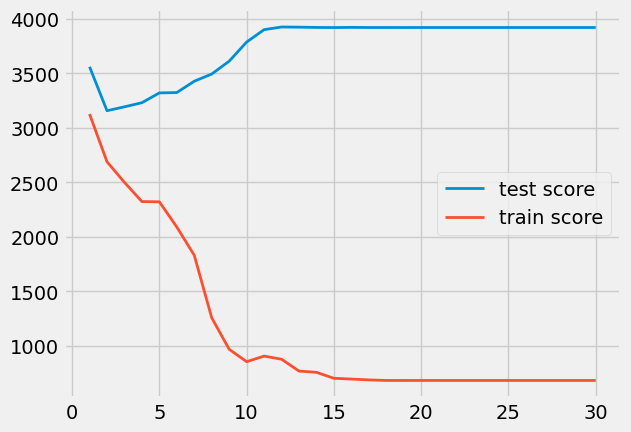

In [103]:
depths = np.arange(1,31,1)
plt.plot(depths,scores,linewidth = 2,label = 'test score')
plt.plot(depths,scores_train,linewidth = 2,label = 'train score')
plt.legend()

On obtient pas bcp mieux...

Maintenant la totale

In [105]:
import warnings

# Suppress FutureWarning messages
pd.options.mode.chained_assignment = None

error = 0
steps = 365
models={}
predictions ={}
i=0
for station in data_X['station'].unique():
        data_X_station = data_X[data_X['station']==station]
        data_X_station = add_lags(data_X_station)
        #data_X_station = create_features(data_X_station)

        #data_X_station = data_X_station.sort_index()


        fold = 0
        preds = []
        scores = []
        print(i,'/',439)
        train = data_X_station[:-steps]
        test = data_X_station[-steps:]

        train = create_features(train)
        test = create_features(test)

        FEATURES = ['dayofweek', 'month','year','dayofmonth',
                'lag1','lag2','lag3','lag4','lag5','lag6',
                'job','vacances','ferie']
        TARGET = 'y'

        X_train = train[FEATURES]
        y_train = train[TARGET]

        X_test = test[FEATURES]
        y_test = test[TARGET]

        reg = xgb.XGBRegressor( 
                                booster='gbtree',    
                                n_estimators=600,
                                early_stopping_rounds=50,
                                objective='reg:squarederror',
                                max_depth=10,
                                learning_rate=0.01
                                )
        reg.fit(X_train, y_train,
                eval_set=[(X_train, y_train), (X_test, y_test)],
                verbose = False)
        models[station] = reg
        y_pred = reg.predict(X_test)
        # preds.append(y_pred)
        error += mean_squared_error(y_test, y_pred)
        # scores.append(score)
        # Create future dataframe
        future = pd.date_range('2023-01-01','2023-06-30', freq='D')
        future_df = pd.DataFrame(index=future)
        future_df['isFuture'] = True
        X_a_tester = pd.read_csv('x_test.csv')
        X_a_tester = X_a_tester[X_a_tester['station']==station]
        X_a_tester['date'] = pd.to_datetime(X_a_tester['date'])
        X_a_tester = X_a_tester.set_index(['date'])
        #X_a_tester = X_a_tester.sort_index()
        #display(X_a_tester)
        future_df['job'] = X_a_tester['job']
        future_df['ferie'] = X_a_tester['ferie']
        future_df['vacances'] = X_a_tester['vacances']
        future_df['station'] = X_a_tester['station']
        #display(future_df)
        data_X_station['isFuture'] = False
        df_and_future = pd.concat([data_X_station, future_df])
        df_and_future = create_features(df_and_future)
        df_and_future = add_lags(df_and_future)
        
        future_w_features = df_and_future.query('isFuture').copy()
        future_w_features['pred'] = reg.predict(future_w_features[FEATURES])
        
        predictions[station] = future_w_features.copy()
        #display(predictions[station])
        i+=1

    


        

0 / 439
1 / 439
2 / 439
3 / 439
4 / 439
5 / 439
6 / 439
7 / 439
8 / 439
9 / 439
10 / 439
11 / 439
12 / 439
13 / 439
14 / 439
15 / 439
16 / 439
17 / 439
18 / 439
19 / 439
20 / 439
21 / 439
22 / 439
23 / 439
24 / 439
25 / 439
26 / 439
27 / 439
28 / 439
29 / 439
30 / 439
31 / 439
32 / 439
33 / 439
34 / 439
35 / 439
36 / 439
37 / 439
38 / 439
39 / 439
40 / 439
41 / 439
42 / 439
43 / 439
44 / 439
45 / 439
46 / 439
47 / 439
48 / 439
49 / 439
50 / 439
51 / 439
52 / 439
53 / 439
54 / 439
55 / 439
56 / 439
57 / 439
58 / 439
59 / 439
60 / 439
61 / 439
62 / 439
63 / 439
64 / 439
65 / 439
66 / 439
67 / 439
68 / 439
69 / 439
70 / 439
71 / 439
72 / 439
73 / 439
74 / 439
75 / 439
76 / 439
77 / 439
78 / 439
79 / 439
80 / 439
81 / 439
82 / 439
83 / 439
84 / 439
85 / 439
86 / 439
87 / 439
88 / 439
89 / 439
90 / 439
91 / 439
92 / 439
93 / 439
94 / 439
95 / 439
96 / 439
97 / 439
98 / 439
99 / 439
100 / 439
101 / 439
102 / 439
103 / 439
104 / 439
105 / 439
106 / 439
107 / 439
108 / 439
109 / 439
110 / 439


c:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [11:55:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:52: Empty dataset at worker: 0
  warnings.warn(smsg, UserWarning)


435 / 439
436 / 439
437 / 439
438 / 439


In [107]:
error/439

1131.1989088840896

In [106]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
y_pred = pd.read_csv('predictions.csv')
y_pred[['date', 'station']] = y_pred['index'].str.split('_', expand=True)
y_pred['date'] = pd.to_datetime(y_pred['date'])
y_pred['y'] = y_pred['y']*0
y_pred_ind = y_pred.copy()
y_pred_ind = y_pred_ind.set_index(['date'])

i = 0

for station, pred in predictions.items():
    #pred = pred.sort_index(by=pred['date'].month)
    print(i)
    pred['date'] = pred.index
    
        # Remplacer la valeur prédite dans y_pred à l'index correspondant
    pred_light = pred.copy()
    pred_light = pred_light[['station','pred','dayofmonth','month']]
    for index in pred.index:
        valeur = pred.loc[(pred['dayofmonth'] == index.day) & (pred['month'] == index.month), 'pred'].values[0]
        y_pred.loc[(y_pred['date'] == index) & (y_pred['station'] == station), 'y'] = valeur
        #print(index)
    i+=1
# Sauvegarder les prédictions dans un fichier CSV
display(y_pred)
y_pred.to_csv('predictions.csv', index=False)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224


KeyboardInterrupt: 

In [ ]:

display(y_pred)

,index,y,date,station
0,2023-01-01_1J7,30.14904,2023-01-01,1J7
1,2023-01-01_O2O,0.00000,2023-01-01,O2O
2,2023-01-01_8QR,0.00000,2023-01-01,8QR
3,2023-01-01_L58,0.00000,2023-01-01,L58
4,2023-01-01_UMC,0.00000,2023-01-01,UMC
...,...,...,...,...
78695,NaN,NaN,NaT,NaN
78696,NaN,NaN,NaT,NaN
78697,NaN,NaN,NaT,NaN
78698,NaN,NaN,NaT,NaN
